In [1]:
#enables loading of local package without install
import sys
sys.path.insert(0, '../src/')
import ggml_ot

import scanpy as sc
import numpy as np 
from scipy import sparse

/home/kuehn/anaconda3/envs/ggml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "/home/kuehn/ot_metric_learning/damin-ggml/data/datasets/" 

'''
#Breastcancer
disease = "breastcancer"
dataset = "b8b5be07-061b-4390-af0a-f9ced877a068.h5ad"
label_col="reported_diseases"
patient_col="donor_id"
'''
'''
#Kidney
disease = "kidney"
dataset = "1c360b0b-eb2f-45a3-aba9-056026b39fa5.h5ad" 
label_col="disease"
patient_col="donor_id"
'''

#Myocardial infarction
dataset = "c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
disease = "myocard_infarct"
label_col="patient_group"  #Fib,Iz,Myo
patient_col="sample"

#test run on kuppe24
#dataset = "snRNA_human_v0.4.h5ad"
dataset = "combined_human_mice_15512_genes_harmony.h5ad" #mice human
patient_col='Donor' #"Sample"
label_col="diagnosis_CK"


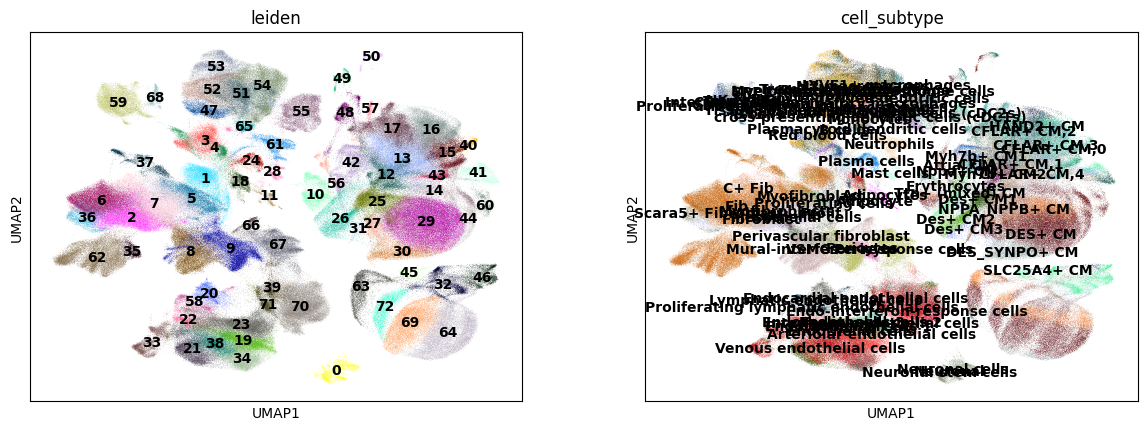

In [3]:
adata = sc.read_h5ad(dataset_path+dataset)

#compute more granular clusters (aka 'cell_subtypes') as 'cell_type' is too broad to learn any meanigful differences
sc.pp.neighbors(adata,use_rep="X_pca_harmony") #X_harmony
sc.tl.leiden(adata, flavor="igraph", resolution=2.0) 
cell_type = "cell_subtype" if "cell_subtype" in adata.obs.keys() else "cell_type"
sc.pl.umap(adata, color=["leiden",cell_type],legend_loc="on data")

In [4]:
#small fixes as structure of merged human mice anndata changed
adata.X = sparse.csr_matrix(adata.X)
adata.obs["cell_type"] = adata.obs["cell_subtype"]

Running GGML with alpha: 10, lambda: 10, rank: 5


100%|██████████| 43/43 [01:38<00:00,  2.28s/it]


Iteration 1 with Loss  355.73252171719537


100%|██████████| 43/43 [01:46<00:00,  2.47s/it]


Iteration 2 with Loss  275.784026289774


100%|██████████| 43/43 [01:37<00:00,  2.27s/it]


Iteration 3 with Loss  256.20557911023724


100%|██████████| 43/43 [01:48<00:00,  2.52s/it]


Iteration 4 with Loss  245.27449532843383


100%|██████████| 43/43 [01:37<00:00,  2.28s/it]


Iteration 5 with Loss  234.0232142201119
Compute all OT distances after 5 iterations


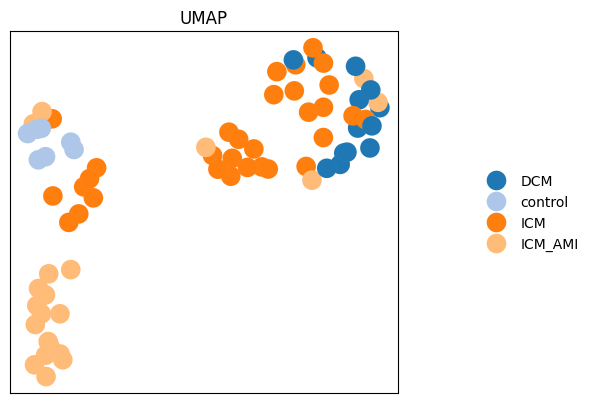

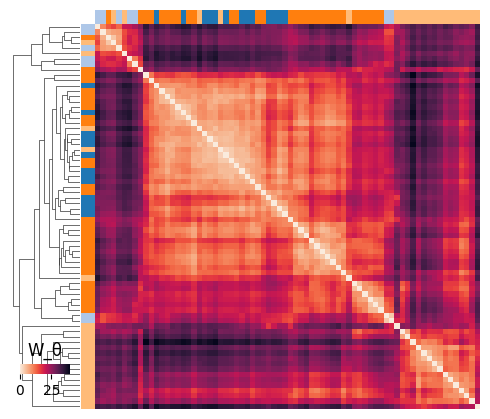

100%|██████████| 43/43 [01:31<00:00,  2.12s/it]


Iteration 6 with Loss  227.4258297925802


100%|██████████| 43/43 [01:23<00:00,  1.93s/it]


Iteration 7 with Loss  223.32249331066572


100%|██████████| 43/43 [01:41<00:00,  2.35s/it]


Iteration 8 with Loss  220.9433223978668


100%|██████████| 43/43 [01:50<00:00,  2.56s/it]


Iteration 9 with Loss  209.92799314432114


100%|██████████| 43/43 [01:36<00:00,  2.24s/it]


Iteration 10 with Loss  210.5012903058758
Compute all OT distances after 10 iterations


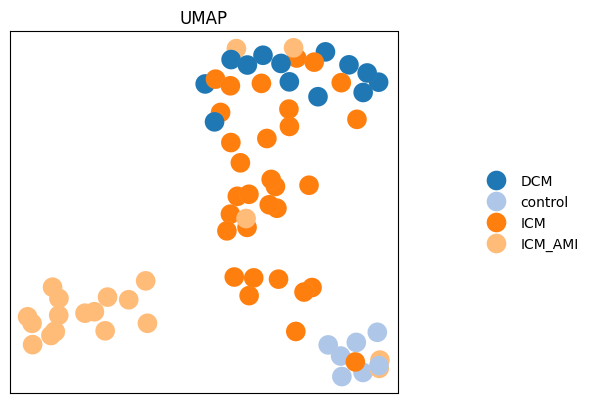

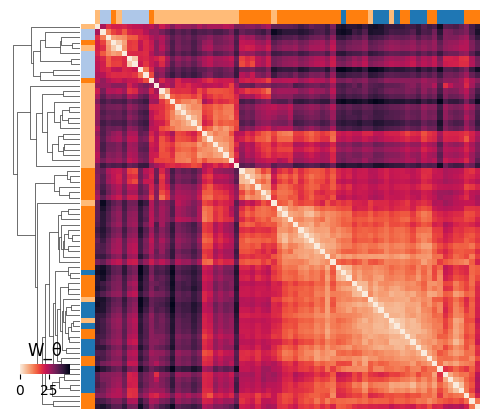

In [5]:
#pass adata object with granular clusters to ggml_dataset and train on 0.75 of patients
train_data = ggml_ot.scRNA_Dataset(adata,label_col=label_col,patient_col=patient_col,group_by="leiden",subsample_patient_ratio=1.0,n_cells=0,use_rep='X_pca_harmony')

n_threads = 64
trained_adata = ggml_ot.ggml(
    train_data, a=10, l=10, norm='cos', max_iterations=10, plot_i_iterations=5, n_threads=n_threads, adata=adata,
)

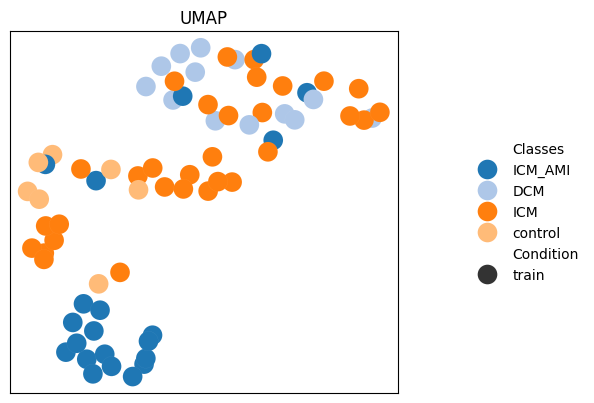

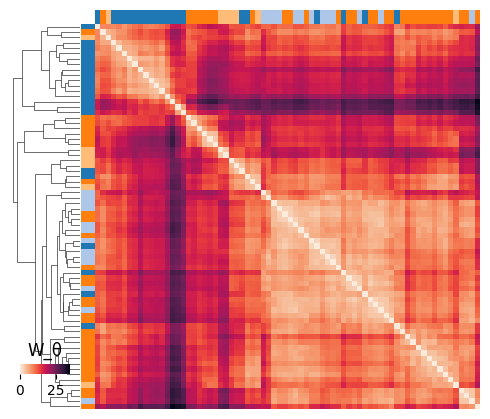

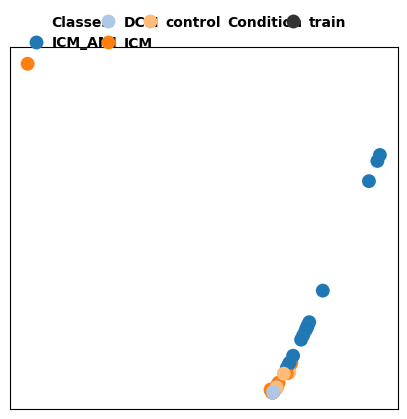

In [9]:
#Test trained weights on full dataset
full_data = ggml_ot.scRNA_Dataset(adata,label_col=label_col,patient_col=patient_col,group_by='cell_type',subsample_patient_ratio=1.0,n_cells=0,use_rep="X_pca_harmony")
train_symbols = ["train" if p in train_data.patient_labels else "test" for p in full_data.patient_labels] 

#D_ggml = full_data.compute_OT_on_dists(w=np.transpose(trained_adata.varm["W_ggml"]), plot=True,symbols=train_symbols,n_threads=200) #TODO having to transpose again is awkward
D_ggml = full_data.compute_OT_on_dists(w=np.transpose(trained_adata.uns["W_ggml"]), plot=True,symbols=train_symbols,n_threads=n_threads) #TODO having to transpose again is awkward

#diffusion map
diff = ggml_ot.plot_emb(D_ggml,"diffusion",colors=full_data.disease_labels,symbols=train_symbols,s=100,title="")

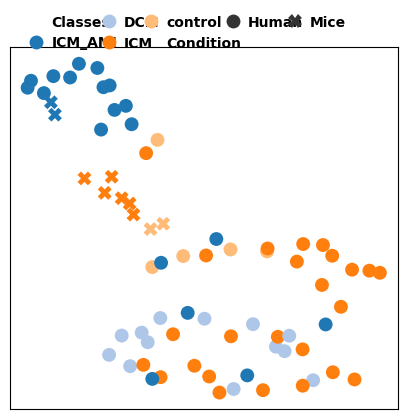

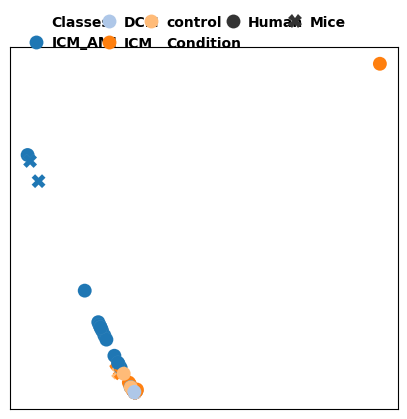

In [10]:
species_symbols = ["Mice" if p in np.unique(adata[adata.obs["batch"]=="mice"].obs[patient_col]) else "Human" for p in full_data.patient_labels] 

diff = ggml_ot.plot_emb(D_ggml,"umap",colors=full_data.disease_labels,symbols=species_symbols ,s=100,title="")
diff = ggml_ot.plot_emb(D_ggml,"diffusion",colors=full_data.disease_labels,symbols=species_symbols ,s=100,title="")


In [11]:
#Showcasing interpretability of subspace axes
%load_ext autoreload
%autoreload 2
import ggml_ot.genes
%load_ext autoreload
%autoreload 2
import ggml_ot.genes

_ = ggml_ot.genes.importance(trained_adata,n_top_genes=10)

top_genes = ggml_ot.genes.importance(trained_adata,n_top_genes=50,plot=False)
ggml_ot.genes.enrichment(top_genes)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Exception: GGML not trained on this Anndata object yet

In [ ]:
#TODO tomorrow, figure out why this crashs the kernel

'''
#Plot cells in subspace (use UMAP for rank > 2)
if trained_adata.obsm["X_ggml"].shape[-1]>2:
    sc.pp.neighbors(trained_adata,use_rep="X_ggml") 
    sc.tl.umap(trained_adata)
    sc.pl.umap(trained_adata,color=[label_col,"leiden","cell_subtype"],show=True,ncols=4)
else:
    sc.pl.embedding(trained_adata,"X_ggml",color=[label_col,"leiden","cell_subtype"],show=True,ncols=4)
'''

0         human
1         human
2         human
3         human
4         human
          ...  
609686     mice
609687     mice
609688     mice
609689     mice
609690     mice
Name: batch, Length: 609691, dtype: category
Categories (2, object): ['human', 'mice']


'\n#Plot cells in subspace (use UMAP for rank > 2)\nif trained_adata.obsm["X_ggml"].shape[-1]>2:\n    sc.pp.neighbors(trained_adata,use_rep="X_ggml") \n    sc.tl.umap(trained_adata)\n    sc.pl.umap(trained_adata,color=[label_col,"leiden","cell_subtype"],show=True,ncols=4)\nelse:\n    sc.pl.embedding(trained_adata,"X_ggml",color=[label_col,"leiden","cell_subtype"],show=True,ncols=4)\n'